<a href="https://colab.research.google.com/github/wtrekell/soylent-army/blob/main/colab/ai_vs_human_v1.4v.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============================================================================
# IMPORTS AND SETUP
# =============================================================================

# Install required packages in Colab environment
try:
    import matplotlib
    import plotly
    import seaborn
except ImportError:
    print("Installing required packages...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly", "matplotlib", "seaborn"])

# Standard library imports
import json
import os
from collections import defaultdict

import matplotlib.patches as patches

# Visualization libraries
import matplotlib.pyplot as plt

# Data analysis libraries
import numpy as np
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

# Global Configuration
plt.style.use("default")
sns.set_palette("husl")
pio.templates.default = "plotly_white"

# Custom color palette for consistency
COLORS = {
    "draft": "#FF6B6B",  # Red
    "refined": "#4ECDC4",  # Teal
    "edited": "#45B7D1",  # Blue
    "final": "#96CEB4",  # Green
    "new_in_final": "#FFA726",  # Orange
    "human": "#2E7D32",  # Dark Green
    "ai": "#1976D2",  # Dark Blue
    "removed": "#F44336"  # Red for removed content
}

print("✅ Imports and setup completed successfully")

✅ Imports and setup completed successfully


In [2]:
# =============================================================================
# CORE UTILITY FUNCTIONS
# =============================================================================

def load_analysis_data(input_path: str) -> dict:
    """Load analysis data from file with error handling."""
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"Analysis file not found: {input_path}")

    try:
        with open(input_path, encoding='utf-8') as f:
            data = json.load(f)
        print(f"📖 Loaded analysis data from: {input_path}")
        return data
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid JSON in file {input_path}: {e}")
    except Exception as e:
        raise RuntimeError(f"Error loading file {input_path}: {e}")

def validate_article_structure(article_data: dict) -> bool:
    """Validate that article data has required structure for visualization."""
    required_fields = [
        'article_name',
        'attribution_analysis',
        'similarity_analysis',
        'processing_summary'
    ]

    for field in required_fields:
        if field not in article_data:
            print(f"⚠️ Missing required field: {field}")
            return False

    # Validate attribution_analysis structure
    if 'statistics' not in article_data.get('attribution_analysis', {}):
        print("⚠️ Missing statistics in attribution_analysis")
        return False

    if 'origin_distribution' not in article_data['attribution_analysis'].get('statistics', {}):
        print("⚠️ Missing origin_distribution in statistics")
        return False

    return True

def ensure_output_directory(output_path: str) -> str:
    """Ensure output directory exists and return absolute path."""
    if not output_path:
        output_path = "visualization_outputs"

    abs_path = os.path.abspath(output_path)
    os.makedirs(abs_path, exist_ok=True)
    return abs_path

def get_article_name_safe(article_data: dict, max_length: int = 50) -> str:
    """Get article name safely with length limiting."""
    name = article_data.get('article_name', 'Unknown Article')
    if len(name) > max_length:
        return name[:max_length-3] + '...'
    return name

def calculate_attribution_summary(articles: list) -> dict:
    """Calculate aggregate attribution statistics across multiple articles."""
    version_totals = defaultdict(lambda: {'total_pct': 0, 'count': 0})

    for article in articles:
        if not validate_article_structure(article):
            continue

        attribution = article['attribution_analysis']['statistics']['origin_distribution']
        for version, stats in attribution.items():
            version_totals[version]['total_pct'] += stats.get('percentage', 0)
            version_totals[version]['count'] += 1

    # Calculate averages
    summary = {}
    for version, totals in version_totals.items():
        if totals['count'] > 0:
            summary[version] = {
                'avg_percentage': totals['total_pct'] / totals['count'],
                'article_count': totals['count']
            }

    return summary

def get_color_for_version(version: str) -> str:
    """Get consistent color for version type."""
    return COLORS.get(version.lower(), COLORS.get('new_in_final', '#CCCCCC'))

def save_figure_multiple_formats(fig, base_path: str, formats: list = None) -> list:
    """Save matplotlib figure in multiple formats."""
    if formats is None:
        formats = ['png', 'pdf', 'svg']

    saved_files = []
    base_dir = os.path.dirname(base_path)
    base_name = os.path.basename(base_path)

    # Remove extension if present
    if '.' in base_name:
        base_name = os.path.splitext(base_name)[0]

    for fmt in formats:
        file_path = os.path.join(base_dir, f"{base_name}.{fmt}")
        try:
            fig.savefig(file_path, format=fmt, dpi=300, bbox_inches='tight')
            saved_files.append(file_path)
        except Exception as e:
            print(f"⚠️ Failed to save {fmt} format: {e}")

    return saved_files

print("🛠️ Core utility functions loaded successfully!")

🛠️ Core utility functions loaded successfully!


In [3]:
# =============================================================================
# VISUALIZATION ENGINE CLASSES
# =============================================================================

class VisualizationEngine:
    """Core visualization engine for creating static matplotlib charts."""

    def __init__(self, output_path: str = None):
        self.output_path = ensure_output_directory(output_path) if output_path else None

    def create_content_flow_chart(self, data, collection_mode=False, title=None):
        """Create content flow chart for individual article or collection."""
        if collection_mode and isinstance(data, list):
            return self._create_collection_content_flow(data, title)
        else:
            return self._create_individual_content_flow(data, title)

    def _create_individual_content_flow(self, data, title=None):
        """Create content flow chart for individual article."""
        if not title:
            title = f"Content Flow: {get_article_name_safe(data)}"

        attribution_stats = data["attribution_analysis"]["statistics"]
        origin_dist = attribution_stats["origin_distribution"]

        # Create matplotlib flow chart
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)

        flow_data = []
        for version, stats in origin_dist.items():
            flow_data.append({
                "source": "New Content" if version == "new_in_final" else version.title(),
                "value": stats["percentage"],
                "count": stats["count"],
            })

        y_positions = np.linspace(8, 2, len(flow_data))
        for i, item in enumerate(flow_data):
            source_color = get_color_for_version(item["source"].lower().replace(" ", "_"))

            # Source box
            source_rect = patches.Rectangle(
                (0.5, y_positions[i] - 0.3), 2, 0.6,
                facecolor=source_color, alpha=0.7, edgecolor="black"
            )
            ax.add_patch(source_rect)
            ax.text(1.5, y_positions[i], item["source"], ha="center", va="center", fontweight="bold")

            # Percentage label
            ax.text(4.5, y_positions[i], f"{item['value']:.1f}%", ha="center", va="center", fontsize=10, fontweight="bold")

        # Target box
        target_rect = patches.Rectangle((7, 4.5), 2, 1, facecolor=COLORS["final"], alpha=0.7, edgecolor="black")
        ax.add_patch(target_rect)
        ax.text(8, 5, "Final Article", ha="center", va="center", fontweight="bold")

        ax.set_title(title, fontsize=16, fontweight="bold", pad=20)
        ax.axis("off")
        return fig

    def _create_collection_content_flow(self, articles, title=None):
        """Create content flow chart for collection of articles."""
        if not title:
            title = f"Collection Content Flow ({len(articles)} Articles)"

        # Calculate aggregate statistics
        aggregate_stats = calculate_attribution_summary(articles)

        fig, ax = plt.subplots(figsize=(12, 8))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)

        flow_data = []
        for version, stats in aggregate_stats.items():
            flow_data.append({
                "source": "New Content" if version == "new_in_final" else version.title(),
                "value": stats["avg_percentage"],
                "count": stats["article_count"],
            })

        y_positions = np.linspace(8, 2, len(flow_data))
        for i, item in enumerate(flow_data):
            source_color = get_color_for_version(item["source"].lower().replace(" ", "_"))

            # Source box
            source_rect = patches.Rectangle(
                (0.5, y_positions[i] - 0.3), 2, 0.6,
                facecolor=source_color, alpha=0.7, edgecolor="black"
            )
            ax.add_patch(source_rect)
            ax.text(1.5, y_positions[i], item["source"], ha="center", va="center", fontweight="bold")

            # Percentage label
            ax.text(4.5, y_positions[i], f"{item['value']:.1f}%", ha="center", va="center", fontsize=10, fontweight="bold")

        # Target box
        target_rect = patches.Rectangle((7, 4.5), 2, 1, facecolor=COLORS["final"], alpha=0.7, edgecolor="black")
        ax.add_patch(target_rect)
        ax.text(8, 5, "Final Articles", ha="center", va="center", fontweight="bold")

        ax.set_title(title, fontsize=16, fontweight="bold", pad=20)
        ax.axis("off")
        return fig

    def create_attribution_breakdown_chart(self, data, collection_mode=False):
        """Create attribution breakdown bar chart."""
        if collection_mode and isinstance(data, list):
            return self._create_collection_attribution_chart(data)
        else:
            return self._create_individual_attribution_chart(data)

    def _create_individual_attribution_chart(self, data):
        """Create attribution bar chart for individual article."""
        attribution_stats = data["attribution_analysis"]["statistics"]
        origin_dist = attribution_stats["origin_distribution"]

        versions = []
        percentages = []
        colors = []

        for version, stats in origin_dist.items():
            display_name = "New Content" if version == "new_in_final" else version.title()
            versions.append(display_name)
            percentages.append(stats["percentage"])
            colors.append(get_color_for_version(version))

        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(versions, percentages, color=colors, alpha=0.7)

        # Add percentage labels on bars
        for bar, pct in zip(bars, percentages, strict=False):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

        ax.set_title(f"Attribution Breakdown: {get_article_name_safe(data)}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Version Type")
        ax.set_ylabel("Percentage (%)")
        ax.set_ylim(0, max(percentages) * 1.1)
        plt.xticks(rotation=45)
        plt.tight_layout()

        return fig

    def _create_collection_attribution_chart(self, articles):
        """Create attribution bar chart for collection."""
        aggregate_stats = calculate_attribution_summary(articles)

        versions = []
        avg_percentages = []
        colors = []

        for version, stats in aggregate_stats.items():
            display_name = "New Content" if version == "new_in_final" else version.title()
            versions.append(display_name)
            avg_percentages.append(stats["avg_percentage"])
            colors.append(get_color_for_version(version))

        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(versions, avg_percentages, color=colors, alpha=0.7)

        # Add percentage labels on bars
        for bar, pct in zip(bars, avg_percentages, strict=False):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')

        ax.set_title(f"Average Attribution Across Collection ({len(articles)} Articles)",
                    fontsize=14, fontweight='bold')
        ax.set_xlabel("Version Type")
        ax.set_ylabel("Average Percentage (%)")
        ax.set_ylim(0, max(avg_percentages) * 1.1)
        plt.xticks(rotation=45)
        plt.tight_layout()

        return fig

    def create_similarity_heatmap(self, data, collection_mode=False):
        """Create similarity analysis heatmap."""
        if collection_mode and isinstance(data, list):
            return self._create_collection_similarity_heatmap(data)
        else:
            return self._create_individual_similarity_heatmap(data)

    def _create_individual_similarity_heatmap(self, data):
        """Create similarity heatmap for individual article."""
        fig, ax = plt.subplots(figsize=(8, 6))

        if 'similarity_analysis' not in data:
            ax.text(0.5, 0.5, 'No similarity analysis data available',
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title(f"Similarity Analysis: {get_article_name_safe(data)}")
            return fig

        similarity_data = data['similarity_analysis']

        # Extract similarity metrics from sequential_analysis array
        comparisons = []
        scores = []

        # Handle sequential_analysis array structure
        if 'sequential_analysis' in similarity_data:
            sequential_analysis = similarity_data['sequential_analysis']

            for seq_item in sequential_analysis:
                if 'version_pair' in seq_item and 'full_text' in seq_item:
                    version_pair = seq_item['version_pair']
                    similarity_score = seq_item['full_text'].get('combined', 0)

                    # Parse version pair (e.g., "draft_to_refined" -> "Draft vs Refined")
                    if '_to_' in version_pair:
                        v1, v2 = version_pair.split('_to_')
                        label = f"{v1.title()} to {v2.title()}"
                    else:
                        label = version_pair.replace('_', ' ').title()

                    comparisons.append(label)
                    scores.append(similarity_score)

        # Also check for draft_to_final comparison
        if 'draft_to_final' in similarity_data:
            draft_final = similarity_data['draft_to_final']
            if 'full_text' in draft_final and 'combined' in draft_final['full_text']:
                similarity_score = draft_final['full_text']['combined']
                comparisons.append("Draft to Final")
                scores.append(similarity_score)

        if scores:
            colors = plt.cm.viridis(scores)
            bars = ax.barh(comparisons, scores, color=colors)

            # Add score labels
            for bar, score in zip(bars, scores, strict=False):
                width = bar.get_width()
                ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                       f'{score:.3f}', ha='left', va='center')

            ax.set_xlabel('Similarity Score')
            ax.set_xlim(0, 1.1)
        else:
            ax.text(0.5, 0.5, 'No similarity comparisons available',
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)

        ax.set_title(f"Similarity Analysis: {get_article_name_safe(data)}")
        plt.tight_layout()

        return fig

    def _create_collection_similarity_heatmap(self, articles):
        """Create similarity heatmap for collection."""
        fig, ax = plt.subplots(figsize=(10, 8))

        # Simplified collection similarity visualization
        ax.text(0.5, 0.5, f'Collection Similarity Analysis\n({len(articles)} articles)\n\nDetailed similarity analysis available\nin interactive visualizations',
               transform=ax.transAxes, ha='center', va='center', fontsize=12)
        ax.set_title("Collection Similarity Overview")

        return fig

    def create_modification_intensity_chart(self, data, collection_mode=False):
        """Create modification intensity visualization."""
        fig, ax = plt.subplots(figsize=(8, 6))

        if collection_mode and isinstance(data, list):
            ax.text(0.5, 0.5, f'Modification Intensity Analysis\n({len(data)} articles)\n\nAggregate modification patterns available',
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title("Collection Modification Intensity")
        else:
            ax.text(0.5, 0.5, f'Modification Intensity Analysis\n{get_article_name_safe(data)}\n\nDetailed modification patterns',
                   transform=ax.transAxes, ha='center', va='center', fontsize=12)
            ax.set_title(f"Modification Intensity: {get_article_name_safe(data)}")

        return fig

    def save_all_charts(self, charts_dict: dict) -> dict:
        """Save all charts to files."""
        if not self.output_path:
            return {}

        saved_files = {}
        for chart_name, fig in charts_dict.items():
            if fig is not None:
                base_path = os.path.join(self.output_path, f"{chart_name}")
                saved_files[chart_name] = save_figure_multiple_formats(fig, base_path)

        return saved_files

class CollectionVisualizationEngine:
    """Specialized visualization engine for collection-level analysis."""

    def __init__(self, output_path: str = None):
        self.output_path = ensure_output_directory(output_path) if output_path else None

    def create_collection_overview_dashboard(self, collection_summary: dict):
        """Create overview dashboard for collection."""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Top left: Version distribution
        versions = list(collection_summary.keys())
        avg_percentages = [stats['avg_percentage'] for stats in collection_summary.values()]
        colors = [get_color_for_version(v) for v in versions]

        ax1.pie(avg_percentages, labels=[v.title().replace('_', ' ') for v in versions],
               colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title("Average Version Distribution")

        # Top right: Article counts
        article_counts = [stats['article_count'] for stats in collection_summary.values()]
        ax2.bar(versions, article_counts, color=colors, alpha=0.7)
        ax2.set_title("Articles per Version Type")
        ax2.set_ylabel("Number of Articles")
        plt.setp(ax2.get_xticklabels(), rotation=45)

        # Bottom left: Summary statistics
        total_articles = max(article_counts) if article_counts else 0
        ax3.text(0.1, 0.8, "Collection Summary:", fontsize=14, fontweight='bold', transform=ax3.transAxes)
        ax3.text(0.1, 0.6, f"Total Articles: {total_articles}", fontsize=12, transform=ax3.transAxes)
        ax3.text(0.1, 0.4, f"Version Types: {len(versions)}", fontsize=12, transform=ax3.transAxes)
        ax3.text(0.1, 0.2, f"Avg Coverage: {sum(avg_percentages):.1f}%", fontsize=12, transform=ax3.transAxes)
        ax3.axis('off')

        # Bottom right: Version comparison
        x = range(len(versions))
        ax4.bar(x, avg_percentages, color=colors, alpha=0.7)
        ax4.set_title("Average Percentages by Version")
        ax4.set_xticks(x)
        ax4.set_xticklabels([v.replace('_', ' ').title() for v in versions], rotation=45)
        ax4.set_ylabel("Average Percentage")

        plt.tight_layout()
        return fig

print("🏗️ Visualization engine classes loaded successfully!")

🏗️ Visualization engine classes loaded successfully!


In [4]:
# =============================================================================
# INTERACTIVE VISUALIZATION FUNCTIONS
# =============================================================================

def create_interactive_flow_chart(data, collection_mode=False):
    """Create an interactive Plotly flow/sankey diagram for individual articles or collections."""
    if collection_mode and isinstance(data, list):
        return _create_interactive_collection_flow_chart(data)
    else:
        return _create_interactive_individual_flow_chart(data)

def _create_interactive_individual_flow_chart(data):
    """Create interactive flow chart for individual article."""
    attribution_stats = data["attribution_analysis"]["statistics"]
    origin_dist = attribution_stats["origin_distribution"]

    # Prepare data for sankey diagram
    sources = []
    targets = []
    values = []
    labels = []

    # Build label list
    version_labels = []
    for version in origin_dist.keys():
        if version != "new_in_final":
            version_labels.append(version.title())
        else:
            version_labels.append("New Content")

    version_labels.append("Final Article")
    labels = version_labels

    # Build flow connections
    final_idx = len(version_labels) - 1
    for i, (version, stats) in enumerate(origin_dist.items()):
        sources.append(i)
        targets.append(final_idx)
        values.append(stats["percentage"])

    # Create colors for nodes
    colors = []
    for version in origin_dist.keys():
        colors.append(get_color_for_version(version))
    colors.append(COLORS["final"])  # Final article color

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=[f"rgba{tuple(list(pc.hex_to_rgb(get_color_for_version(list(origin_dist.keys())[i]))) + [0.6])}" for i in range(len(sources))]
        )
    )])

    fig.update_layout(
        title_text=f"Content Flow: {get_article_name_safe(data)}",
        font_size=12,
        height=400
    )

    return fig

def _create_interactive_collection_flow_chart(articles):
    """Create interactive flow chart for collection of articles."""
    # Calculate aggregate flows across collection
    aggregate_attribution = calculate_attribution_summary(articles)

    # Prepare data for sankey diagram
    sources = []
    targets = []
    values = []
    labels = []

    # Build label list
    version_labels = []
    for version in aggregate_attribution.keys():
        if version != "new_in_final":
            version_labels.append(version.title())
        else:
            version_labels.append("New Content")

    version_labels.append("Final Articles")
    labels = version_labels

    # Build flow connections
    final_idx = len(version_labels) - 1
    for i, (version, stats) in enumerate(aggregate_attribution.items()):
        sources.append(i)
        targets.append(final_idx)
        values.append(stats["avg_percentage"])

    # Create colors for nodes
    colors = []
    for version in aggregate_attribution.keys():
        colors.append(get_color_for_version(version))
    colors.append(COLORS["final"])  # Final articles color

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=[f"rgba{tuple(list(pc.hex_to_rgb(get_color_for_version(list(aggregate_attribution.keys())[i]))) + [0.6])}" for i in range(len(sources))]
        )
    )])

    fig.update_layout(
        title_text=f"Collection Content Flow ({len(articles)} Articles)",
        font_size=12,
        height=400
    )

    return fig

def create_interactive_attribution_bar_chart(data, collection_mode=False):
    """Create interactive bar chart showing attribution percentages."""
    if collection_mode and isinstance(data, list):
        return _create_interactive_collection_bar_chart(data)
    else:
        return _create_interactive_individual_bar_chart(data)

def _create_interactive_individual_bar_chart(data):
    """Create interactive bar chart for individual article."""
    attribution_stats = data["attribution_analysis"]["statistics"]
    origin_dist = attribution_stats["origin_distribution"]

    versions = []
    percentages = []
    colors = []

    for version, stats in origin_dist.items():
        display_name = "New Content" if version == "new_in_final" else version.title()
        versions.append(display_name)
        percentages.append(stats["percentage"])
        colors.append(get_color_for_version(version))

    fig = go.Figure(data=[
        go.Bar(
            x=versions,
            y=percentages,
            marker_color=colors,
            text=[f"{p:.1f}%" for p in percentages],
            textposition='auto',
            hovertemplate='<b>%{x}</b><br>Percentage: %{y:.1f}%<extra></extra>'
        )
    ])

    fig.update_layout(
        title=f"Attribution Breakdown: {get_article_name_safe(data)}",
        xaxis_title="Version Type",
        yaxis_title="Percentage (%)",
        showlegend=False,
        height=400
    )

    return fig

def _create_interactive_collection_bar_chart(articles):
    """Create interactive bar chart for collection."""
    aggregate_attribution = calculate_attribution_summary(articles)

    versions = []
    avg_percentages = []
    article_counts = []
    colors = []

    for version, stats in aggregate_attribution.items():
        display_name = "New Content" if version == "new_in_final" else version.title()
        versions.append(display_name)
        avg_percentages.append(stats["avg_percentage"])
        article_counts.append(stats["article_count"])
        colors.append(get_color_for_version(version))

    fig = go.Figure(data=[
        go.Bar(
            x=versions,
            y=avg_percentages,
            marker_color=colors,
            text=[f"{p:.1f}%" for p in avg_percentages],
            textposition='auto',
            customdata=article_counts,
            hovertemplate='<b>%{x}</b><br>Average: %{y:.1f}%<br>Articles: %{customdata}<extra></extra>'
        )
    ])

    fig.update_layout(
        title=f"Average Attribution Across Collection ({len(articles)} Articles)",
        xaxis_title="Version Type",
        yaxis_title="Average Percentage (%)",
        showlegend=False,
        height=400
    )

    return fig

def create_interactive_comparison_heatmap(articles):
    """Create interactive heatmap comparing articles in a collection."""
    if len(articles) > 20:
        print("⚠️ Too many articles for heatmap display. Limiting to first 20.")
        articles = articles[:20]

    article_names = [get_article_name_safe(article, 25) for article in articles]
    version_types = ['draft', 'refined', 'edited', 'new_in_final']
    version_labels = ['Draft', 'Refined', 'Edited', 'New Content']

    # Build data matrix
    z_data = []
    for article in articles:
        row = []
        if validate_article_structure(article):
            attribution = article['attribution_analysis']['statistics']['origin_distribution']
            for version_type in version_types:
                percentage = attribution.get(version_type, {}).get('percentage', 0)
                row.append(percentage)
        else:
            row = [0, 0, 0, 0]  # Default values for invalid articles
        z_data.append(row)

    fig = go.Figure(data=go.Heatmap(
        z=z_data,
        x=version_labels,
        y=article_names,
        colorscale='Viridis',
        hoverongaps=False,
        hovertemplate='<b>%{y}</b><br>%{x}: %{z:.1f}%<extra></extra>'
    ))

    fig.update_layout(
        title="Article Attribution Comparison Heatmap",
        xaxis_title="Version Type",
        yaxis_title="Articles",
        height=max(400, len(articles) * 25),
        yaxis=dict(tickmode='linear'),
    )

    return fig

def create_interactive_similarity_scatter(data, collection_mode=False):
    """Create interactive scatter plot showing similarity metrics."""
    if collection_mode and isinstance(data, list):
        return _create_collection_similarity_scatter(data)
    else:
        return _create_individual_similarity_scatter(data)

def _create_individual_similarity_scatter(data):
    """Create similarity scatter plot for individual article."""
    if 'similarity_analysis' not in data:
        print("⚠️ No similarity analysis data available")
        return go.Figure().add_annotation(text="No similarity data available", showarrow=False)

    similarity_data = data['similarity_analysis']

    # Extract similarity metrics from sequential_analysis array
    x_vals = []
    y_vals = []
    labels = []
    colors = []

    # Handle sequential_analysis array structure
    if 'sequential_analysis' in similarity_data:
        sequential_analysis = similarity_data['sequential_analysis']

        for i, seq_item in enumerate(sequential_analysis):
            if 'version_pair' in seq_item and 'full_text' in seq_item:
                version_pair = seq_item['version_pair']
                # Extract similarity score from nested structure
                similarity_score = seq_item['full_text'].get('combined', 0)

                # Parse version pair (e.g., "draft_to_refined" -> "Draft to Refined")
                if '_to_' in version_pair:
                    v1, v2 = version_pair.split('_to_')
                    label = f"{v1.title()} to {v2.title()}"
                    color_key = v1
                else:
                    label = version_pair.replace('_', ' ').title()
                    color_key = version_pair.split('_')[0] if '_' in version_pair else version_pair

                x_vals.append(similarity_score)
                y_vals.append(i + 1)  # Use position as y-value
                labels.append(label)
                colors.append(get_color_for_version(color_key))

    # Also check for draft_to_final comparison
    if 'draft_to_final' in similarity_data:
        draft_final = similarity_data['draft_to_final']
        if 'full_text' in draft_final and 'combined' in draft_final['full_text']:
            similarity_score = draft_final['full_text']['combined']
            x_vals.append(similarity_score)
            y_vals.append(len(x_vals))  # Use position as y-value
            labels.append("Draft to Final")
            colors.append(get_color_for_version('draft'))

    fig = go.Figure()

    if x_vals:
        fig.add_trace(go.Scatter(
            x=x_vals,
            y=y_vals,
            mode='markers+text',
            marker=dict(
                size=15,
                color=colors,
                line=dict(width=2, color='white')
            ),
            text=labels,
            textposition='middle right',
            hovertemplate='<b>%{text}</b><br>Similarity: %{x:.3f}<extra></extra>'
        ))

        fig.update_layout(
            title=f"Version Similarity Analysis: {get_article_name_safe(data)}",
            xaxis_title="Similarity Score (0-1)",
            yaxis=dict(visible=False),
            height=400,
            showlegend=False
        )
    else:
        fig.add_annotation(text="No similarity data available", showarrow=False)

    return fig

def _create_collection_similarity_scatter(articles):
    """Create similarity scatter plot for collection."""
    similarity_scores = []
    article_names = []

    for article in articles:
        if 'similarity_analysis' in article:
            # Get average similarity from sequential_analysis
            similarity_data = article['similarity_analysis']
            total_similarity = 0
            count = 0

            # Process sequential_analysis array
            if 'sequential_analysis' in similarity_data:
                for seq_item in similarity_data['sequential_analysis']:
                    if 'full_text' in seq_item and 'combined' in seq_item['full_text']:
                        total_similarity += seq_item['full_text']['combined']
                        count += 1

            # Also include draft_to_final if available
            if 'draft_to_final' in similarity_data:
                draft_final = similarity_data['draft_to_final']
                if 'full_text' in draft_final and 'combined' in draft_final['full_text']:
                    total_similarity += draft_final['full_text']['combined']
                    count += 1

            if count > 0:
                avg_similarity = total_similarity / count
                similarity_scores.append(avg_similarity)
                article_names.append(get_article_name_safe(article, 30))

    if similarity_scores:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=list(range(len(similarity_scores))),
            y=similarity_scores,
            mode='markers+text',
            marker=dict(
                size=10,
                color=similarity_scores,
                colorscale='viridis',
                showscale=True,
                colorbar=dict(title="Avg Similarity")
            ),
            text=article_names,
            textposition='top center',
            hovertemplate='<b>%{text}</b><br>Avg Similarity: %{y:.3f}<extra></extra>'
        ))

        fig.update_layout(
            title=f"Collection Similarity Overview ({len(articles)} Articles)",
            xaxis_title="Article Index",
            yaxis_title="Average Similarity Score",
            height=400,
            showlegend=False
        )
    else:
        fig = go.Figure()
        fig.add_annotation(text="No similarity data available", showarrow=False)

    return fig

print("🎯 Interactive visualization functions loaded successfully!")

🎯 Interactive visualization functions loaded successfully!


In [5]:
# =============================================================================
# DATA INPUT HANDLER AND MAIN INTERFACE
# =============================================================================

class DataInputHandler:
    """Handles loading and validation of various data input formats."""

    def __init__(self):
        self.supported_formats = ['json']

    def load_and_validate(self, input_data: str | dict | list) -> dict:
        """Load and normalize data from various input formats."""
        if isinstance(input_data, str):
            # File path provided
            data = load_analysis_data(input_data)
        else:
            # Data already loaded
            data = input_data

        # Normalize data structure
        if isinstance(data, list):
            # Array of articles
            articles = data
            collection_metadata = {}
        elif isinstance(data, dict):
            if 'articles' in data:
                # Collection with articles
                articles = data['articles']
                collection_metadata = {k: v for k, v in data.items() if k != 'articles'}
            else:
                # Single article
                articles = [data]
                collection_metadata = {}
        else:
            raise ValueError(f"Unsupported data format: {type(data)}")

        # Validate articles
        validated_articles = []
        for i, article in enumerate(articles):
            if validate_article_structure(article):
                validated_articles.append(article)
            else:
                print(f"⚠️ Skipping invalid article at index {i}")

        if not validated_articles:
            raise ValueError("No valid articles found in input data")

        return {
            'articles': validated_articles,
            'collection_metadata': collection_metadata
        }

def load_and_visualize(input_data: str | dict | list, output_path: str = None, save_files: bool = True) -> dict:
    """
    Universal function to load and visualize either individual articles or collections.
    """
    print("🚀 Starting load_and_visualize...")

    # Initialize data handler and load data
    data_handler = DataInputHandler()
    normalized_data = data_handler.load_and_validate(input_data)

    articles = normalized_data['articles']
    metadata = normalized_data['collection_metadata']

    # Prepare output directory
    if save_files and output_path:
        output_path = ensure_output_directory(output_path)

    # Determine visualization mode
    is_collection = len(articles) > 1

    if is_collection:
        print(f"📊 Collection mode: {len(articles)} articles")
        return visualize_article_collection(articles, output_path, save_files, metadata)
    else:
        print("📊 Individual article mode")
        return visualize_individual_article(articles[0], output_path, save_files)

def visualize_individual_article(analysis_data, output_path=None, save_files=True):
    """Create visualizations for a single article analysis."""
    print(f"🎨 Creating visualizations for: {get_article_name_safe(analysis_data)}")

    # Initialize visualization engine
    viz_engine = VisualizationEngine(output_path)
    results = {}

    try:
        # Static visualizations
        print("📊 Creating static charts...")
        static_charts = {
            'content_flow': viz_engine.create_content_flow_chart(analysis_data),
            'attribution_breakdown': viz_engine.create_attribution_breakdown_chart(analysis_data),
            'similarity_analysis': viz_engine.create_similarity_heatmap(analysis_data),
            'modification_intensity': viz_engine.create_modification_intensity_chart(analysis_data)
        }

        # Interactive visualizations
        print("🎯 Creating interactive charts...")
        interactive_charts = {
            'interactive_flow': create_interactive_flow_chart(analysis_data),
            'interactive_attribution': create_interactive_attribution_bar_chart(analysis_data),
            'interactive_similarity': create_interactive_similarity_scatter(analysis_data)
        }

        # Save files if requested
        saved_files = {}
        if save_files and output_path:
            saved_files = viz_engine.save_all_charts(static_charts)
            print(f"💾 Static charts saved to: {output_path}")

        results = {
            'article_name': get_article_name_safe(analysis_data),
            'static_charts': static_charts,
            'interactive_charts': interactive_charts,
            'saved_files': saved_files,
            'output_path': output_path,
            'visualization_type': 'individual'
        }

        print("✅ Individual article visualization completed!")
        return results

    except Exception as e:
        print(f"❌ Error creating visualizations: {str(e)}")
        return {'error': str(e), 'article_name': get_article_name_safe(analysis_data)}

def visualize_article_collection(articles, output_path=None, save_files=True, metadata=None):
    """Create visualizations for a collection of articles."""
    print(f"🎨 Creating collection visualizations for {len(articles)} articles...")

    # Initialize visualization engines
    viz_engine = VisualizationEngine(output_path)
    collection_engine = CollectionVisualizationEngine(output_path)

    results = {}

    try:
        # Collection-level static visualizations
        print("📊 Creating collection static charts...")
        collection_summary = calculate_attribution_summary(articles)

        static_charts = {
            'collection_overview': collection_engine.create_collection_overview_dashboard(collection_summary),
            'collection_flow': viz_engine.create_content_flow_chart(articles, collection_mode=True),
            'comparative_attribution': viz_engine.create_attribution_breakdown_chart(articles, collection_mode=True),
            'article_comparison_matrix': viz_engine.create_similarity_heatmap(articles, collection_mode=True)
        }

        # Collection-level interactive visualizations
        print("🎯 Creating collection interactive charts...")
        interactive_charts = {
            'interactive_collection_flow': create_interactive_flow_chart(articles, collection_mode=True),
            'interactive_collection_attribution': create_interactive_attribution_bar_chart(articles, collection_mode=True),
            'interactive_comparison_heatmap': create_interactive_comparison_heatmap(articles),
            'interactive_similarity_overview': create_interactive_similarity_scatter(articles, collection_mode=True)
        }

        # Individual article summaries (limited detail for collections)
        individual_summaries = []
        for i, article in enumerate(articles[:10]):  # Limit to first 10 for performance
            try:
                summary = {
                    'article_name': get_article_name_safe(article),
                    'mini_flow_chart': viz_engine.create_content_flow_chart(article, title=f"Flow: {get_article_name_safe(article, 20)}")
                }
                individual_summaries.append(summary)
            except Exception as e:
                print(f"⚠️ Error creating summary for article {i}: {str(e)}")

        # Save files if requested
        saved_files = {}
        if save_files and output_path:
            saved_files = viz_engine.save_all_charts(static_charts)
            print(f"💾 Collection charts saved to: {output_path}")

        results = {
            'collection_metadata': metadata or {},
            'article_count': len(articles),
            'collection_summary': collection_summary,
            'static_charts': static_charts,
            'interactive_charts': interactive_charts,
            'individual_summaries': individual_summaries,
            'saved_files': saved_files,
            'output_path': output_path,
            'visualization_type': 'collection'
        }

        print("✅ Collection visualization completed!")
        return results

    except Exception as e:
        print(f"❌ Error creating collection visualizations: {str(e)}")
        return {'error': str(e), 'article_count': len(articles)}

def viz_analysis(analysis_data_or_file, output_path=None):
    """
    Main analysis function - this is the primary interface for users.
    """
    print("🔬 Starting viz_analysis...")
    return load_and_visualize(analysis_data_or_file, output_path)

print("🎯 Main interface functions loaded successfully!")

🎯 Main interface functions loaded successfully!


📁 Enter the path to your JSON analysis file: /content/markup-languages_complete_analysis.json

🚀 Processing file: /content/markup-languages_complete_analysis.json
📊 Creating all visualizations...
🔬 Starting viz_analysis...
🚀 Starting load_and_visualize...
📖 Loaded analysis data from: /content/markup-languages_complete_analysis.json
📊 Individual article mode
🎨 Creating visualizations for: markup-languages
📊 Creating static charts...
🎯 Creating interactive charts...
💾 Static charts saved to: /content/final_analysis
✅ Individual article visualization completed!

✅ Analysis completed successfully!
📄 Article(s): markup-languages
📊 Visualization type: individual

🎯 Displaying 3 interactive visualizations...
  📈 Showing Interactive Flow


  📈 Showing Interactive Attribution


  📈 Showing Interactive Similarity



💾 Static charts saved to: /content/final_analysis
   Files created: 4 chart types

🎉 All visualizations generated successfully!

✨ Analysis complete!


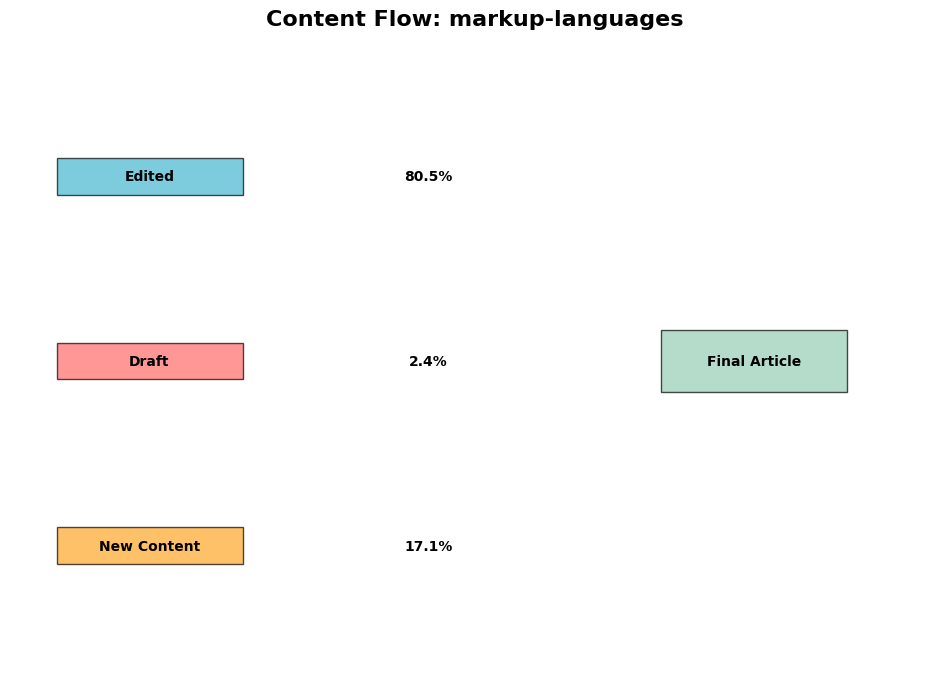

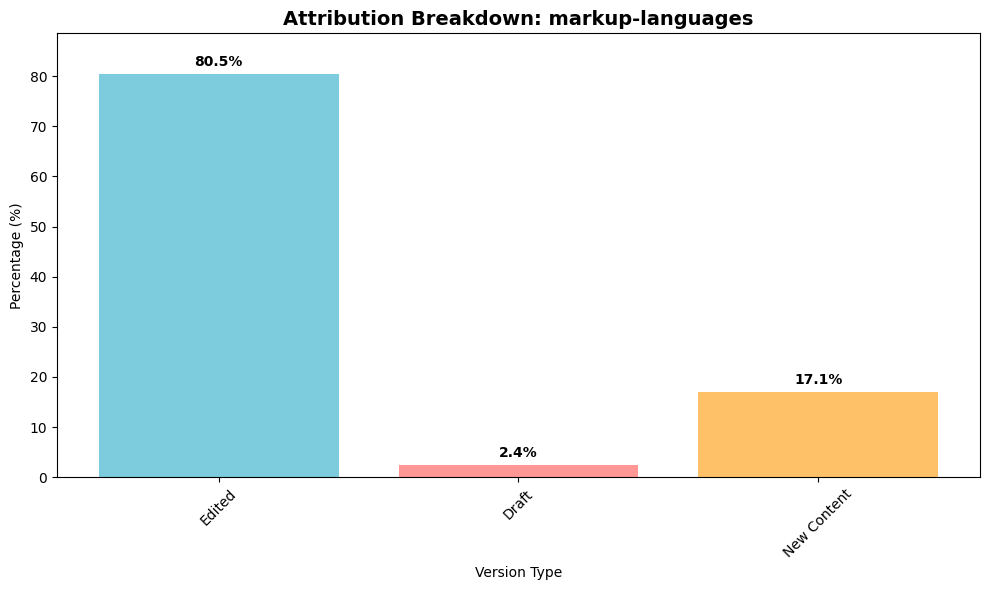

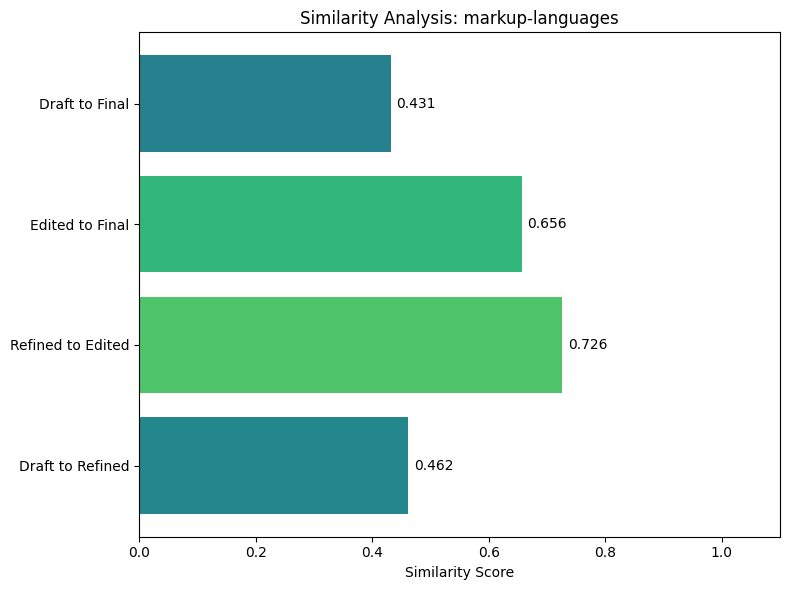

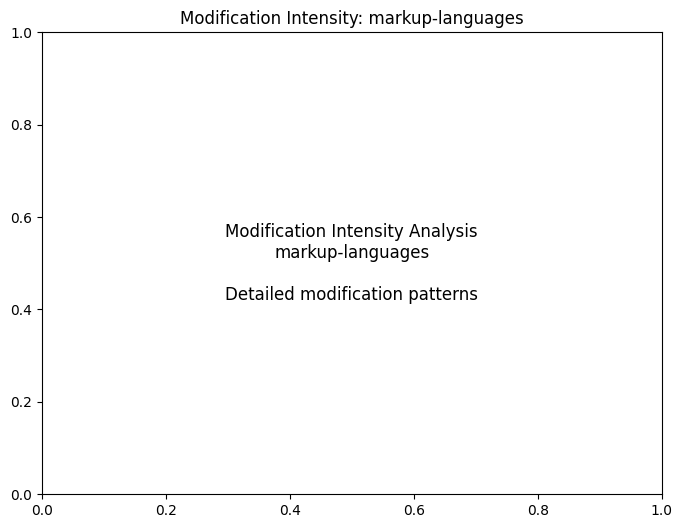

In [7]:
# =============================================================================
# USER INPUT AND VISUALIZATION EXECUTION
# =============================================================================

# Enter the path to your JSON analysis file here:
json_file_path = input("📁 Enter the path to your JSON analysis file: ")

# Determine output path relative to the JSON file
output_directory = os.path.join(os.path.dirname(json_file_path), "final_analysis")

# Process the file and create all visualizations
print(f"\n🚀 Processing file: {json_file_path}")
print("📊 Creating all visualizations...")

try:
    # Run the complete analysis
    analysis_results = viz_analysis(json_file_path, output_path=output_directory)

    # Display results summary
    if 'error' not in analysis_results:
        print("\n✅ Analysis completed successfully!")
        print(f"📄 Article(s): {analysis_results.get('article_name', analysis_results.get('article_count', 'Multiple articles'))}")
        print(f"📊 Visualization type: {analysis_results.get('visualization_type', 'Unknown')}")

        # Display interactive charts automatically
        if 'interactive_charts' in analysis_results:
            print(f"\n🎯 Displaying {len(analysis_results['interactive_charts'])} interactive visualizations...")
            for chart_name, chart in analysis_results['interactive_charts'].items():
                print(f"  📈 Showing {chart_name.replace('_', ' ').title()}")
                chart.show()

        # Show static charts info if any were saved
        if analysis_results.get('saved_files'):
            print(f"\n💾 Static charts saved to: {analysis_results.get('output_path')}")
            print(f"   Files created: {len(analysis_results['saved_files'])} chart types")

        print("\n🎉 All visualizations generated successfully!")

    else:
        print(f"\n❌ Error occurred: {analysis_results['error']}")

except Exception as error:
    print(f"\n❌ Failed to process file: {str(error)}")
    print("\n🔍 Please check that:")
    print("   • The file path is correct")
    print("   • The file exists and is readable")
    print("   • The file contains valid JSON data")
    print("   • The JSON has the expected analysis structure")

print("\n✨ Analysis complete!")